<p style="font-size:18pt"> Increase cells size </p>

In [18]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

<p style="font-size:18pt"> Basic map code </p>

In [19]:
from ipyleaflet import Map
basic_map = Map(zoom = 1)
basic_map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<p style="font-size:18pt"> Basic .gpx file opening </p>

In [20]:
import gpxpy
#gpx_file_path = 'Gran_Fondo_Porto_SantElpidio_2022.gpx'
gpx_file_path = 'Cesena_Fontanella_Pantani_Sorrivoli_Centenara_Cesena.gpx'

with open(gpx_file_path) as fh:
    gpxFile = gpxpy.parse(fh)

<p style="font-size:18pt"> Import of packages </p>

In [21]:
from statistics import mean
#import ipyleaflet
from ipyleaflet import basemaps, FullScreenControl, LayerGroup, \
    MeasureControl, Polyline, Marker, CircleMarker, WidgetControl
from ipywidgets import Button, HTML, HBox, VBox, Checkbox, FileUpload, \
    Label, Output, IntSlider, Layout, Image, link
from bqplot import pyplot as plt
from bqplot import *

<p style="font-size:18pt"> .gpx file in a map </p>

In [22]:
#def plot_map(gpx):
"""
Plot the GPS trace on a map
"""
from ipyleaflet import Map

points = [p.point for p in gpxFile.get_points_data(distance_2d=True)]
mean_lat = mean(p.latitude for p in points)
mean_lng = mean(p.longitude for p in points)

# create the map
m = Map(center=(mean_lat, mean_lng), zoom=12, basemap=basemaps.Stamen.Terrain)

# show trace
line = Polyline(locations=[[[p.latitude, p.longitude] for p in points],],
                color = "red", fill=False)
m.add_layer(line)

# add markers
waypoints = [
    Marker(location=(point.latitude, point.longitude), title=point.name,
           popup=HTML(value=point.name), draggable=False)
    for point in gpxFile.waypoints
]
waypoints_layer = LayerGroup(layers=waypoints)
#m.add_layer(waypoints_layer)

# add a checkbox to show / hide waypoints
waypoints_checkbox = Checkbox(value=True, description='Show Waypoints')

def update_visible(change):
    for p in waypoints:
        p.visible = change['new']

waypoints_checkbox.observe(update_visible, 'value')
waypoint_control = WidgetControl(widget=waypoints_checkbox, position='bottomright')
m.add_control(waypoint_control)

# enable full screen mode
m.add_control(FullScreenControl())

# add measure control
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)
m.add_control(measure)

#return m
m

Map(center=[44.079069151812824, 12.218333058224683], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [23]:
# https://www.youtube.com/watch?v=jAKUPm-Cul0
#j = 90
#gpxFile.get_points_data(distance_2d=True)[j]#.tracks().segments[j]

<p style="font-size:18pt"> bqplot representation of altitude </p>

In [24]:
#def plot_elevation(gpx):
"""
Return an elevation graph for the given gpx trace
"""
points = gpxFile.get_points_data(distance_2d=True)
px = [p.distance_from_start / 1000 for p in points]
py = [p.point.elevation for p in points]

x_scale, y_scale = LinearScale(), LinearScale()
x_scale.allow_padding = False
x_ax = Axis(label='Distance (km)', scale=x_scale)
y_ax = Axis(label='Elevation (m)', scale=y_scale, orientation='vertical')

lines = Lines(x=px, y=py, scales={'x': x_scale, 'y': y_scale})

u = 90
elevation = Figure(title='Elevation Chart %d' %u, axes=[x_ax, y_ax], marks=[lines])


elevation.layout.width = 'auto'
elevation.layout.height = 'auto'
elevation.layout.min_height = '300px'

#elevation.interaction = IndexSelector(scale=x_scale)
#return elevation
elevation

Figure(axes=[Axis(label='Distance (km)', scale=LinearScale(allow_padding=False)), Axis(label='Elevation (m)', …

<p style="font-size:18pt"> from .gpx file to Pandas dataframe  </p>

In [25]:
import pandas as pd

j = 0
points = []
for segment in gpxFile.tracks[j].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
coords = pd.DataFrame.from_records(points)

<p style="font-size:18pt"> pandas datetime conversion into a integer of seconds  </p>

In [26]:
from datetime import datetime
timeList = [ datetime.timestamp( u ) for u in coords['time'] ]

<p style="font-size:18pt"> intervals of space, time and elevation. Speed calculation  </p>

In [27]:
DeltaTime = np.diff(timeList)
DeltaTime = np.append([0], DeltaTime)
coords['DeltaTime'] = pd.Series( DeltaTime )

#111.139e3 converts latitude/longitude into metres
DeltaLat = np.diff( coords['latitude'] )*111.139e3
DeltaLong = np.diff( coords['longitude'] )*111.139e3
DeltaElev = np.diff( coords['elevation'] )
DeltaSpace = ( DeltaLat**2 + DeltaLong**2 + DeltaElev**2 )**.5
steepness = DeltaElev/DeltaSpace

coords['steepness'] = pd.Series(steepness)
coords['DeltaSpace'] = pd.Series( DeltaSpace )
coords['DeltaSpace'].replace([np.inf, -np.inf], np.nan, inplace=True)

coords['speed'] = 3.6*coords['DeltaSpace']/coords['DeltaTime']
coords['speed'].replace([np.inf, -np.inf], np.nan, inplace=True)#removes singolarities
coords.head()

,time,latitude,longitude,elevation,DeltaTime,steepness,DeltaSpace,speed
0,2022-10-02 15:13:49+00:00,44.140379,12.238573,34.0,0.0,-0.019334,5.172216,NaN
1,2022-10-02 15:13:50+00:00,44.140386,12.238527,33.9,1.0,-0.011440,8.741073,31.467864
2,2022-10-02 15:13:52+00:00,44.140402,12.238450,33.8,2.0,-0.025171,3.972826,7.151087
3,2022-10-02 15:13:53+00:00,44.140413,12.238416,33.7,1.0,-0.015628,6.398759,23.035534
4,2022-10-02 15:13:55+00:00,44.140430,12.238361,33.6,2.0,-0.011584,8.632295,15.538132


<p style="font-size:18pt"> Select outlayers  </p>

In [28]:
#in a bike gpx track, a difference of speeds of 10 km/h or more in between two gps points
#is highly unreasonable. Here points showing such a speed difference are discarted
diffSpeed = np.diff(coords['speed'])
maxSpeedDiff = 10
#speed difference excess indexes
inLayers = np.where( abs( diffSpeed ) < maxSpeedDiff )[0] 
outLayers = np.where( abs( diffSpeed ) > maxSpeedDiff )[0]

<IPython.core.display.Javascript object>


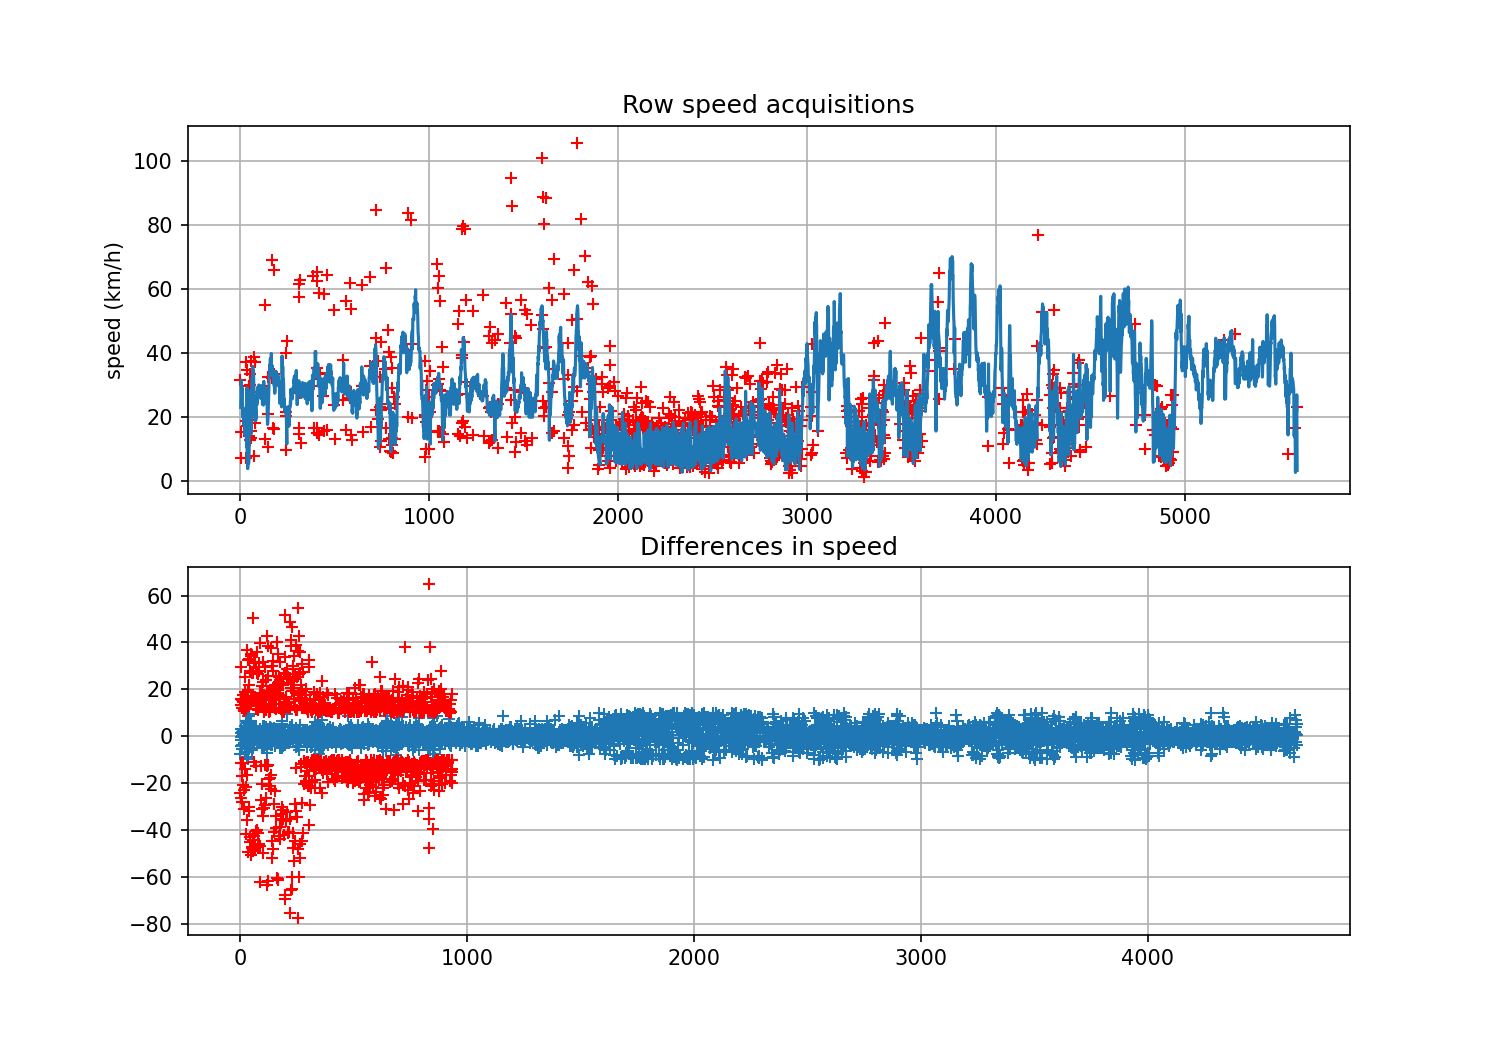

In [29]:
import matplotlib.pyplot as mp
%matplotlib notebook

mp.figure(figsize=(10,7))
mp.subplot(211)
mp.title('Row speed acquisitions')
mp.ylabel('speed (km/h)')
mp.plot(coords['speed'][outLayers], 'r+')
mp.plot(coords['speed'][inLayers])#, 'b--')
mp.grid()

mp.subplot(212)
mp.title('Differences in speed')
mp.plot(diffSpeed[inLayers], '+')
mp.plot(diffSpeed[outLayers], 'r+')
mp.grid()
mp.show()

<p style="font-size:14pt"> Speeds of 100 km/h reported in the plots above are highly unreasonable for a bike tour. Hence, a difference of speed in between adjacent gps acquisitions are reported, which correspond to an interval of time of about 1 sec. Measurements of speed which exceed a difference of 10 km/h in one second are rejected and plotted with red crosses   </p>

<p style="font-size:18pt"> Iterative average over N speeds  </p>

$$
N\bar{x}_0 = x_0 + x_1 + \dots x_{N-1} \\
N\bar{x}_1 = x_1 + x_2 + \dots x_{N} = N\bar{x}_0 - x_0 + x_N \\
N\bar{x}_2 = x_2 + x_3 + \dots x_{N+1} = N\bar{x}_1 - x_1 + x_{N+1} \\
\dots\\
N\bar{x}_j = x_j + x_{j+N-1} + \dots x_{N} = N\bar{x}_{j-1} - x_j + x_{N+j-1} \\
$$

In [30]:
N = 10 # number of speeds to be averaged

avSpeed = [] # iterative average speed
firstSpeed = coords['speed'][inLayers].iloc[:10].sum()/N #average of first N speeds
avSpeed = avSpeed + [ firstSpeed ]

loopEnd = len(coords['speed'][inLayers]) - 10#.index[-1] to be checked
for j in range(loopEnd):
    xj = coords['speed'][inLayers].iloc[j]
    xjN = coords['speed'][inLayers].iloc[ N+j-1 ]
    avSpeed = avSpeed + [ avSpeed[j] + ( -xj + xjN )/N ]

In [40]:
idxs = coords['speed'][inLayers].index + int(N/2) #index of avSpeed centered
coords['avSpeed'] = pd.Series(avSpeed)
coords['avSpeed'].reindex(idxs)

8       21.692712
10      21.137189
11      21.368882
12      20.706120
13      19.856927
14      19.602967
15      19.367550
16      19.270251
17      19.043924
18      19.058882
19      17.895175
20      18.585211
21      17.680951
22      17.531634
23      16.046471
24      15.097570
25      13.945905
26      13.080631
27      12.643186
28      12.141139
29      10.493377
30      11.702558
31      12.290190
32      14.728282
33      15.175023
34      16.359887
35      18.345060
39      25.028903
41      27.370391
43      30.620776
44      31.430376
45      32.100416
46      31.222618
47      29.980183
48      29.371646
49      28.087312
50      26.559492
53      22.541484
54      21.447717
59      23.178596
61      24.530038
63      25.955027
64      26.170016
66      26.668170
67      27.220840
68      27.832393
69      28.194032
70      28.059004
71      28.172055
72      28.329792
73      28.459999
74      28.232115
75      28.215417
76      28.190161
80      27.540787
81      27

<IPython.core.display.Javascript object>


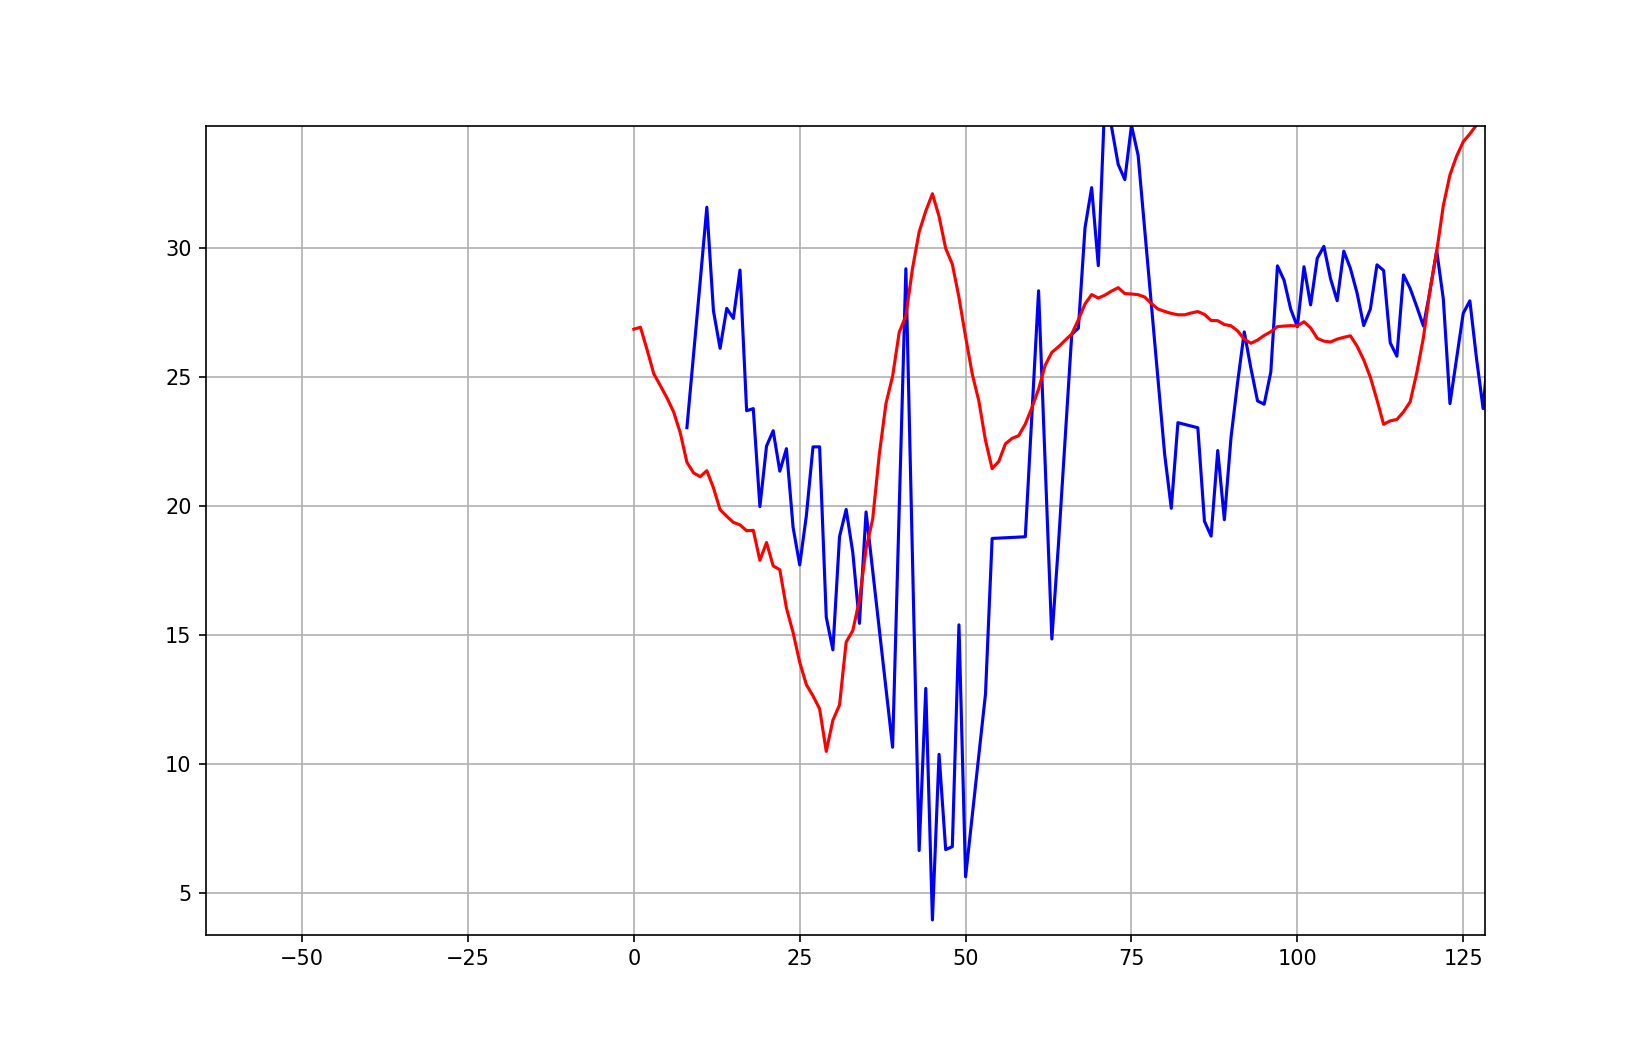

In [45]:
#Display ALL rows
#pd.set_option('display.max_rows', None)
#coords['speed'][inLayers]


mp.figure(figsize = (11, 7) )
mp.plot(idxs, coords['speed'][inLayers], 'b')
mp.plot(coords['avSpeed'], 'r')
mp.grid()
mp.show()

In [33]:
#Display ALL rows
pd.set_option('display.max_rows', None)
coords['avSpeed']#[inLayers]

0       26.852297
1       26.926165
2       26.054210
3       25.128768
4       24.664258
5       24.188423
6       23.644840
7       22.835311
8       21.692712
9       21.285509
10      21.137189
11      21.368882
12      20.706120
13      19.856927
14      19.602967
15      19.367550
16      19.270251
17      19.043924
18      19.058882
19      17.895175
20      18.585211
21      17.680951
22      17.531634
23      16.046471
24      15.097570
25      13.945905
26      13.080631
27      12.643186
28      12.141139
29      10.493377
30      11.702558
31      12.290190
32      14.728282
33      15.175023
34      16.359887
35      18.345060
36      19.494513
37      22.009811
38      23.971859
39      25.028903
40      26.735611
41      27.370391
42      29.209253
43      30.620776
44      31.430376
45      32.100416
46      31.222618
47      29.980183
48      29.371646
49      28.087312
50      26.559492
51      25.119388
52      24.069456
53      22.541484
54      21.447717
55      21

Float64Index([   8.0,   10.0,   11.0,   12.0,   13.0,   14.0,   15.0,   16.0,
                17.0,   18.0,
              ...
              5590.0, 5592.0, 5593.0, 5594.0, 5595.0, 5596.0, 5597.0, 5598.0,
              5599.0, 5601.0],
             dtype='float64', length=4660)